# Mars Craters Detection

### Pre-processing steps
- Cover Mars map with quadrangles
- select a few relevant quadrangles, close to the equator, thus only a little distorted
- reprojection to correct the distortions
- craters: radius from 5 to 28 pixels

In [22]:
import numpy as np

import pandas as pd

import datetime

from utils import *

from matplotlib.patches import Circle

from ObjectDetector import *

from CraterClassifier import *

In [2]:
# !pip install -r requirements.txt

Let's take a look at the data

In [3]:
X_train = np.load('data/data_train.npy', mmap_mode='r')
X_test = np.load('data/data_test.npy', mmap_mode='r')

y_train = pd.read_csv('data/labels_train.csv')
y_test = pd.read_csv('data/labels_test.csv')


print("The train data is made of {} images of {}x{} pixels".format(*X_train.shape))
print("The test data is made of {} images of {}x{} pixels".format(*X_test.shape))


n_img = len(X_train)

The train data is made of 7500 images of 224x224 pixels
The test data is made of 4000 images of 224x224 pixels


- Splitting the test data into valid and test

In [4]:
X_valid = X_test[:2000]
X_test = X_test[2000:]

y_valid = y_test[y_test["i"] < 2000]
y_test = y_test[y_test["i"] >= 2000]

print("The train data is made of {} images of {}x{} pixels".format(*X_train.shape))
print("The valid data is made of {} images of {}x{} pixels".format(*X_valid.shape))
print("The test data is made of {} images of {}x{} pixels".format(*X_test.shape))

The train data is made of 7500 images of 224x224 pixels
The valid data is made of 2000 images of 224x224 pixels
The test data is made of 2000 images of 224x224 pixels


Let's see some images

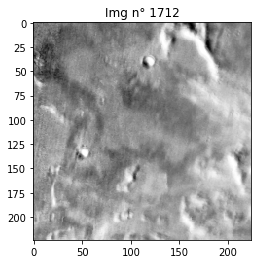

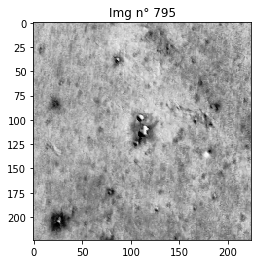

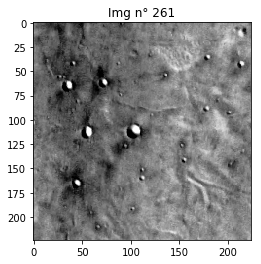

In [5]:
show_images(n_images=3, imgs=X_train, cmap='Greys_r')

In [6]:
y_train.head()

,i,row_p,col_p,radius_p
0,0,57.0,175.0,6.70
1,1,57.0,7.0,6.70
2,4,37.0,70.0,5.25
3,4,121.0,66.0,8.35
4,7,145.0,71.0,6.70


In [7]:
idx_list = [30, 3470, 7030]

Let's plot images + labels

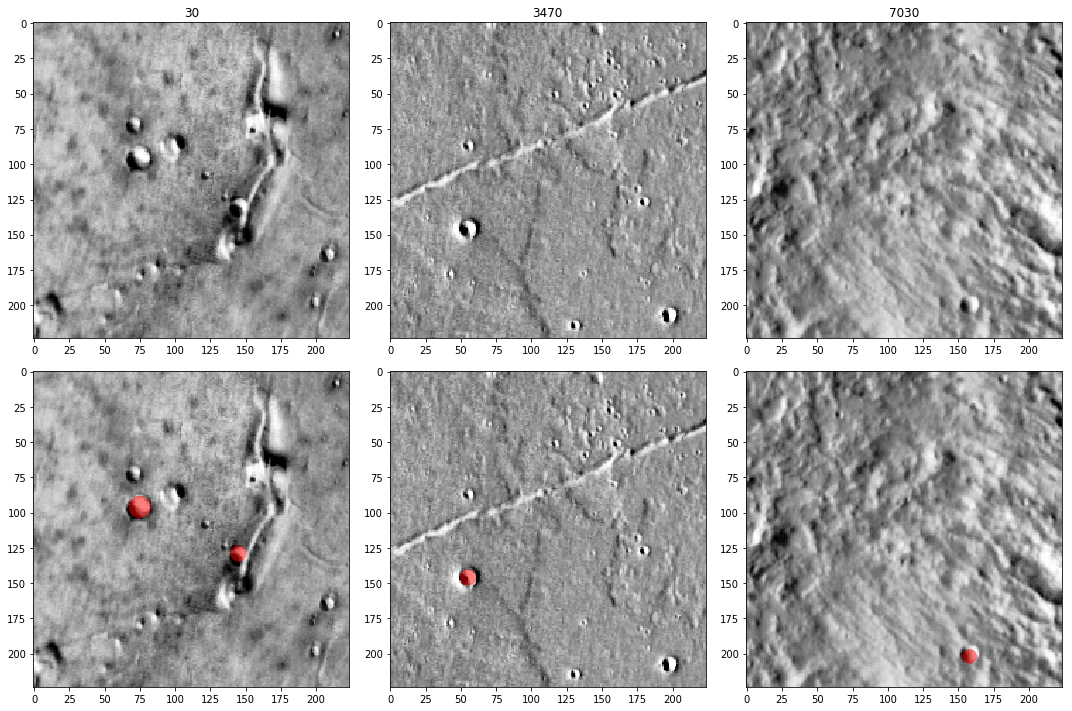

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_list):
    img = X_train[idx]
    lab = y_train[y_train['i'] == idx][['row_p', 'col_p', 'radius_p']].values
    # First row images only
    axes[0, i].imshow(img, cmap='Greys_r')
    axes[0, i].set_title('%d' % idx)
    # Second row, labels overlaid on the image
    axes[1, i].imshow(img, cmap='Greys_r')
    if lab.size != 0:
        for y, x, radius in lab:
            crater = Circle((x, y), radius, color='r', ec=None, alpha=0.5)
            axes[1, i].add_patch(crater)
fig.tight_layout()

In [9]:
print("There are {} labeled craters in the training set".format(y_train.shape[0]))

There are 7541 labeled craters in the training set


In [10]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters for only {:.1%} of the images".format(n_img_withcraters / n_img))

There are labeled craters for only 57.0% of the images


Text(0.5, 1.0, 'Crater radius frequency for the training data')

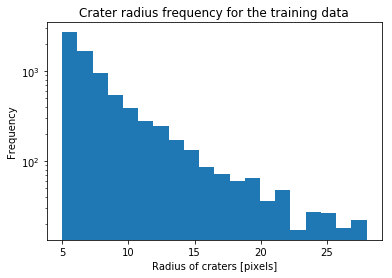

In [11]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

### To-do
- Convert round circles to bounding boxes
- Get train, valid and test data

### Qs
- 

### SSD steps
- Generate multiple boxes?
- keep only boxes that overlap with GT > 0.5
- Define loss function ... 
- To handle different ratios: use the output feature maps of different layers. Previous work: using feature maps for previous layes improves semantic seg
- 

### Extra step: build classification model

- Build classif label

In [12]:
y_train_classif = binarize_y_classification(y_train)
y_valid_classif = binarize_y_classification(y_valid)
y_test_classif = binarize_y_classification(y_test)

In [13]:
config = {
    "n_classes" : 1,
    "mode" : 'train',
    "img_width" : 224,
    "img_height" : 224,
    "n_channels" : 1,
    "base_filter_nums" : [32, 48, 64, 64, 48, 32],
    "base_filter_sizes" : [5, 3, 3, 3, 3, 3],
    "pool_sizes" : [2, 2, 2, 2, 2, None],
    "dense_layers" : 2,
    "dense_units" : [256, 256],
    "batch_size" : 64,
    "n_epochs" : 50,
    "initial_lr" : 1e-4
}

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [15]:
y_train_classif = y_train_classif.reshape(y_train_classif.shape[0], 1)
y_valid_classif = y_valid_classif.reshape(y_valid_classif.shape[0], 1)
y_test_classif = y_test_classif.reshape(y_test_classif.shape[0], 1)

## Training

In [23]:
tf.reset_default_graph()

model = CraterClassifier(config=config)

print("Building graph")

model.build_graph()
session = tf.Session()

now = datetime.datetime.now()
t = str(now.day) + '-' + str(now.hour) + '-' + str(now.minute)
path_model = "model_{}".format(t)

print("Training model")

model.fit(X_train=X_train[:200], y_train=y_train_classif[:200], X_valid=X_valid[:40], y_valid=y_valid_classif[:40], session=session, path_model=path_model, t=t)

Building graph
Building block 1
Building block 2
Building block 3
Building block 4
end conv shape: (?, 3, 3, 32)
flat shape : (?, 288)
Shape after dense layer n°1 : (?, 256)
Shape after dense layer n°2 : (?, 256)
Shape after last dense layer (logit layer): (?, 1)
TRaining model
Epoch 0: Train:  loss: 11.148419380187988, acc: 0.546875
Epoch 0: Valid: loss: nan, acc: nan
Model saved in path: model_29-15-39/model.ckpt


KeyboardInterrupt: 

- Exploding gradient: valid accuracies and losses 0 